## Validação Cruzada e Bootstrap

__________


A **validação cruzada** é uma técnica usada em aprendizado de máquina para avaliar a performance de um modelo de forma mais confiável e evitar que ele apenas “decore” os dados de treino (overfitting).

Em vez de treinar o modelo em todos os dados e testá-lo apenas uma vez, a validação cruzada divide o conjunto de dados em partes (folds) e faz múltiplos testes:

1. O modelo é treinado em algumas partes e testado na parte que sobrou.
2. Esse processo se repete várias vezes, alternando qual parte é usada para teste.
3. No final, calcula-se a média das métricas de todas as iterações, dando uma estimativa mais estável da performance real do modelo.

O tipo mais comum é o k-fold cross-validation, onde os dados são divididos em k partes iguais. Por exemplo, em 5-fold, o modelo treina em 4 partes e testa na 5ª, repetindo até que cada parte tenha sido usada como teste.

**Quando usar?**

* Quando o conjunto de dados é pequeno ou médio: Se você simplesmente separar os dados em treino e teste uma única vez, o resultado pode depender muito dessa divisão específica. A validação cruzada usa várias divisões diferentes, reduzindo o risco de uma avaliação enviesada.

* Quando precisa comparar modelos: Ao testar diferentes algoritmos (ex: regressão logística vs. árvore de decisão) ou diferentes hiperparâmetros, a validação cruzada fornece uma métrica mais estável para decidir qual modelo realmente performa melhor.

* Quando está ajustando hiperparâmetros: Durante o tuning (como escolher taxa de aprendizado, profundidade da árvore, número de vizinhos no KNN etc.), a validação cruzada evita que você escolha parâmetros que funcionam bem apenas em uma divisão específica dos dados.

* Para reduzir overfitting na avaliação: Ela ajuda a detectar se o modelo está apenas “decorando” os dados de treino, pois testa o desempenho em múltiplos subconjuntos diferentes.

**Quando não é necessário?** 
* Em dados temporais (séries temporais), o k-fold tradicional não é ideal — nesse caso, usa-se validação baseada em janela temporal.
* Quando você tem muitos dados (milhões de registros), uma simples divisão treino/teste já costuma ser suficiente.

____


O **bootstrap** é uma técnica de amostragem estatística usada para estimar propriedades de uma população (como média, variância ou intervalo de confiança) a partir de uma amostra limitada de dados, sem precisar de suposições fortes sobre a distribuição original.

A ideia básica é a seguinte:
1. Você tem uma amostra original de dados.
2. Gera novas amostras “resampleadas” da mesma dimensão, sorteando com reposição (ou seja, um mesmo dado pode aparecer mais de uma vez).
3. Calcula a estatística desejada (como média, mediana ou desvio padrão) em cada uma dessas novas amostras.
4. Analisa a distribuição dessas estatísticas para estimar, por exemplo, intervalos de confiança ou incertezas.

O grande benefício do bootstrap é que ele permite quantificar a incerteza das estimativas mesmo quando você tem poucos dados ou não sabe a distribuição exata da população.

________

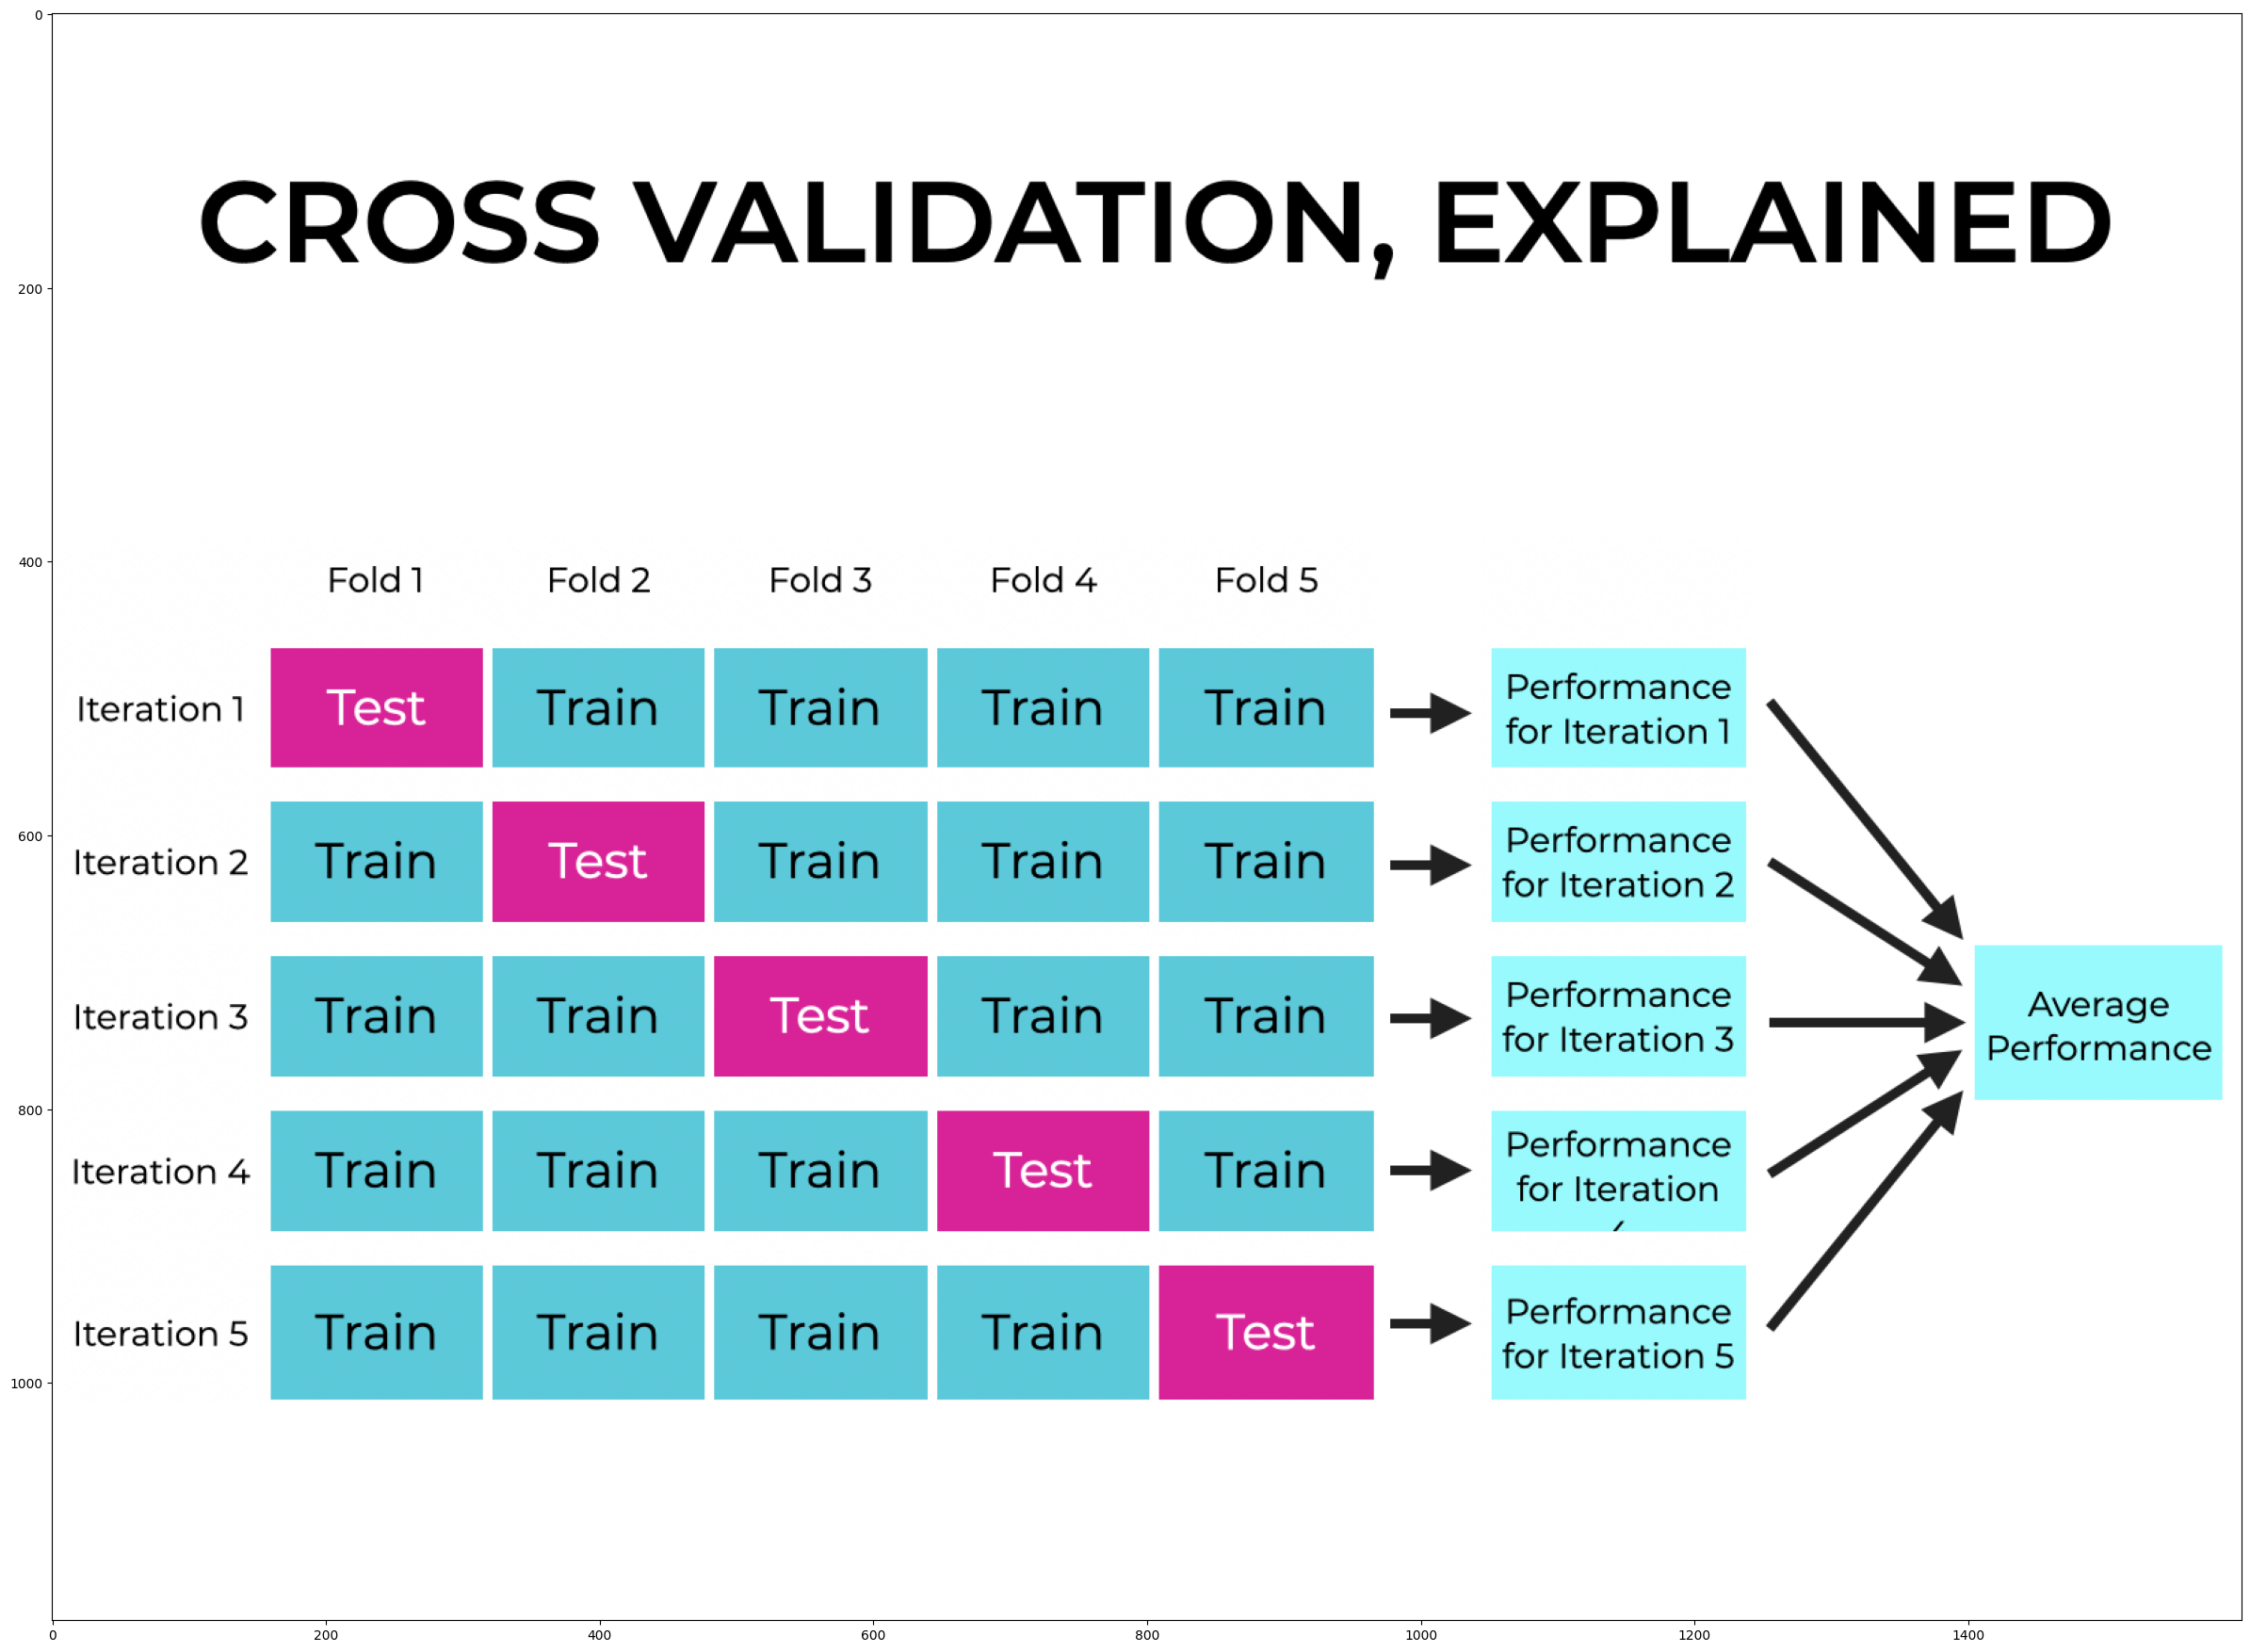

In [19]:
import matplotlib.pyplot as plt 

im = plt.imread('./images/kfold.png')
plt.figure(figsize = (30,30))
plt.imshow(im)
plt.show()

## Hands-on!

1. Importações

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix



2. Carrega dados 

In [21]:
pd.set_option('display.max_columns', None) #visualizar todas as colunas
df = pd.read_csv(".\datasets\Churn_Modelling.csv", encoding = 'utf-8', sep= ';')
df.head()

<>:2: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:2: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
C:\Users\alice\AppData\Local\Temp\ipykernel_5276\1275396298.py:2: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
  df = pd.read_csv(".\datasets\Churn_Modelling.csv", encoding = 'utf-8', sep= ';')


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Esses dados representam um conjunto de informações de clientes de um banco ou instituição financeira. 

* RowNumber: Número da linha, provavelmente um índice de identificação de cada registro (não é uma informação diretamente relevante sobre o cliente, apenas um identificador sequencial).
* CustomerId: Um identificador único para cada cliente, usado para distinguir entre os diferentes clientes no banco de dados.
* Surname: Sobrenome do cliente.
* CreditScore: Pontuação de crédito do cliente, que é uma medida da confiabilidade do cliente para emprestar dinheiro, com base em seu histórico financeiro.
* Geography: País ou região de residência do cliente (exemplo: França, Espanha).
* Gender: Gênero do cliente (exemplo: Feminino).
* Age: Idade do cliente.
* Tenure: O tempo que o cliente tem de relacionamento com a instituição financeira, provavelmente em anos.
* Balance: O saldo bancário do cliente, ou seja, quanto dinheiro ele tem na conta bancária.
* NumOfProducts: O número de produtos que o cliente possui com a instituição financeira (por exemplo, contas bancárias, cartões de crédito, empréstimos).
* HasCrCard: Indica se o cliente possui um cartão de crédito (1 = sim, 0 = não).
* IsActiveMember: Indica se o cliente é um membro ativo (1 = sim, 0 = não), sugerindo que ele está utilizando os serviços da instituição financeira de maneira regular.
* EstimatedSalary: O salário estimado do cliente.
* Exited: Indicador binário que mostra se o cliente saiu da instituição financeira (1 = saiu, 0 = permaneceu). Isso pode ser um alvo para análise de churn (taxa de evasão), ou seja, se o cliente cancelou sua conta ou deixou de usar os serviços.

Objetivo: utilizar técnicas de aprendizado de máquina para prever quais clientes estão mais propensos a "exitar" (sair).

3. Tratamento de dados

In [22]:
one_hot_cols = ['Geography', 'Gender']
drop_cols = ['RowNumber', 'CustomerId', 'Surname'] + one_hot_cols

# Criar a pipeline
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), one_hot_cols)
        ],
        remainder='drop'
    ))
])

# Aplicar a pipeline ao DataFrame
transformed_df = pipeline.fit_transform(df)

# Converter o resultado de volta para um DataFrame
transformed_df = pd.DataFrame(transformed_df)

# Adicionar os nomes das colunas de volta
one_hot_encoded_cols = pipeline.named_steps['preprocessor'] \
                              .named_transformers_['onehot'] \
                              .get_feature_names_out(one_hot_cols)

transformed_df.columns = one_hot_encoded_cols

# Concatenar com as colunas restantes do DataFrame original
df = pd.concat([df.drop(columns=drop_cols), transformed_df], axis=1)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0,1.0,0.0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0,1.0,0.0
2,502,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0,1.0,0.0
3,699,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0,1.0,0.0
4,850,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0,1.0,0.0


4. Separando os dados em treino e teste

In [23]:
X = df.drop(columns='Exited')
y = df['Exited']

5. Equilibrando target

In [24]:
df['Exited'].value_counts(normalize=True)*100 #percentual de exited e nao exited

Exited
0    80.719716
1    19.280284
Name: proportion, dtype: float64

In [25]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [26]:
y_resampled.value_counts(normalize=True)*100

Exited
1    50.0
0    50.0
Name: proportion, dtype: float64

In [27]:
# Dividir os dados em treino e teste # hold out
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

6. Normalizando os dados

In [28]:
scaler = MinMaxScaler()

pipeline = Pipeline([
    ('scaler', scaler)
])

pipeline.fit(x_train, y_train)

x_train_scaled = pipeline.fit_transform(x_train)
x_test_scaled = pipeline.fit_transform(x_test)

x_train_scaled = pd.DataFrame(x_train_scaled, columns=X.columns )
x_test_scaled = pd.DataFrame(x_test_scaled, columns=X.columns)

7. Testando o modelo com validação cruzada

In [29]:
modelo_RFC_cv = RandomForestClassifier(class_weight='balanced',
                                       n_estimators= 200,
                                       max_depth= 8,
                                       random_state=42)

scores = cross_val_score(modelo_RFC_cv, x_train_scaled, y_train, cv=10, scoring='accuracy')

print(scores)
print("Acurácia média com validação cruzada:", scores.mean())

[0.86861925 0.88451883 0.87615063 0.87112971 0.88274707 0.88693467
 0.89028476 0.88190955 0.85008375 0.87437186]
Acurácia média com validação cruzada: 0.8766750068333298


              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2044
           1       0.89      0.84      0.86      1938

    accuracy                           0.87      3982
   macro avg       0.87      0.87      0.87      3982
weighted avg       0.87      0.87      0.87      3982



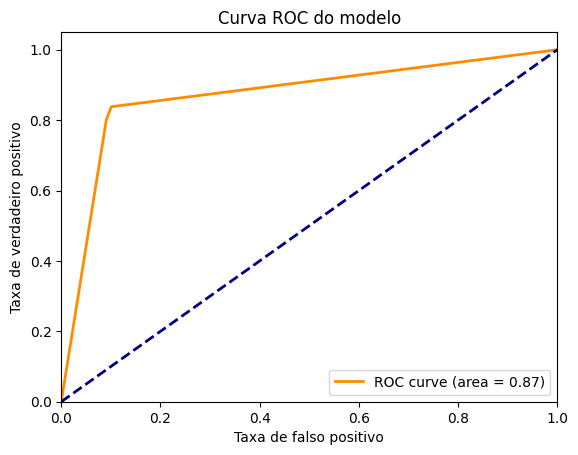

[[1850  194]
 [ 316 1622]]


In [30]:
modelo_RFC_cv.fit(x_train_scaled, y_train)

y_pred = modelo_RFC_cv.predict(x_test_scaled)

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)


fpr_smooth = np.linspace(fpr[0], fpr[-1], 100)
tpr_smooth = np.interp(fpr_smooth, fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr_smooth, tpr_smooth, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva ROC do modelo')
plt.legend(loc="lower right")
plt.show()

matriz = confusion_matrix(y_test, y_pred)
print(matriz)

8. Testando com modelo de bootstrap

In [31]:
# Modificando o RandomForestClassifier para usar bootstrap
modelo_RFC_b = RandomForestClassifier(class_weight='balanced',
                                      n_estimators=200,
                                      max_depth=8,
                                      random_state=42,
                                      bootstrap=True)

# cross-validation
scores = cross_val_score(modelo_RFC_b, x_train_scaled, y_train, cv=10, scoring='accuracy')

print(scores)
print("Acurácia média com validação cruzada:", scores.mean())

[0.86861925 0.88451883 0.87615063 0.87112971 0.88274707 0.88693467
 0.89028476 0.88190955 0.85008375 0.87437186]
Acurácia média com validação cruzada: 0.8766750068333298


              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2044
           1       0.89      0.84      0.86      1938

    accuracy                           0.87      3982
   macro avg       0.87      0.87      0.87      3982
weighted avg       0.87      0.87      0.87      3982



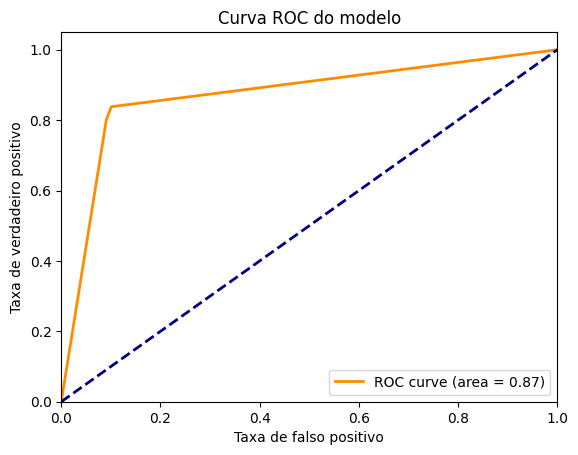

[[1850  194]
 [ 316 1622]]


In [32]:
modelo_RFC_b.fit(x_train_scaled, y_train)

y_pred = modelo_RFC_b.predict(x_test_scaled)

print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

fpr_smooth = np.linspace(fpr[0], fpr[-1], 100)
tpr_smooth = np.interp(fpr_smooth, fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr_smooth, tpr_smooth, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falso positivo')
plt.ylabel('Taxa de verdadeiro positivo')
plt.title('Curva ROC do modelo')
plt.legend(loc="lower right")
plt.show()

matriz = confusion_matrix(y_test, y_pred)
print(matriz)